## ECSE 552 Deep Learning Assignment 4 - Coding Part
## Group Number: 20
## Group Members: Gauri Sharma (261026894) 

### Imports and Configurations

In [96]:
# Data Manipulation
import numpy as np
import pandas as pd
import scipy

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

# Filepath Manipulation
import os

# Train-Test Split
from sklearn.model_selection import train_test_split

# Progress Bars
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdate

In [97]:
# Set the random seed
torch.manual_seed(0)
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [98]:
# nvidia-smi is a command line tool that provides information about the NVIDIA GPU
!nvidia-smi

Mon Apr 17 12:25:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 30%   39C    P8    16W / 320W |   2280MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data Loading

In [99]:
DATA_DIR = "/home/gauri/ecse552/ass4" # Change this to the path where you have downloaded the data
TRAIN_CSV = os.path.join(DATA_DIR, "weather_train.csv")
TEST_CSV = os.path.join(DATA_DIR, "weather_test.csv")



In [100]:
# Load the data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)


In [101]:
train_df.head() # Display the first 5 rows of the training data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [102]:
test_df.head() # Display the first 5 rows of the test data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,24.05.2015 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,7.37,11.79,1179.50,1.58,2.16,34.37
1,24.05.2015 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,7.51,12.03,1183.33,0.23,0.60,20.89
2,24.05.2015 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,7.61,12.18,1188.07,0.26,0.52,252.00
3,24.05.2015 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,7.50,12.01,1191.32,1.22,1.88,218.50
4,24.05.2015 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,7.46,11.95,1194.85,1.43,1.96,218.00


In [103]:
train_df.info() # Display the information about the training data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56072 entries, 0 to 56071
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        56072 non-null  object 
 1   p (mbar)         56072 non-null  float64
 2   T (degC)         56072 non-null  float64
 3   Tpot (K)         56072 non-null  float64
 4   Tdew (degC)      56072 non-null  float64
 5   rh (%)           56072 non-null  float64
 6   VPmax (mbar)     56072 non-null  float64
 7   VPact (mbar)     56072 non-null  float64
 8   VPdef (mbar)     56072 non-null  float64
 9   sh (g/kg)        56072 non-null  float64
 10  H2OC (mmol/mol)  56072 non-null  float64
 11  rho (g/m**3)     56072 non-null  float64
 12  wv (m/s)         56072 non-null  float64
 13  max. wv (m/s)    56072 non-null  float64
 14  wd (deg)         56072 non-null  float64
dtypes: float64(14), object(1)
memory usage: 6.4+ MB


In [104]:
test_df.info() # Display the information about the test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14019 entries, 0 to 14018
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        14019 non-null  object 
 1   p (mbar)         14019 non-null  float64
 2   T (degC)         14019 non-null  float64
 3   Tpot (K)         14019 non-null  float64
 4   Tdew (degC)      14019 non-null  float64
 5   rh (%)           14019 non-null  float64
 6   VPmax (mbar)     14019 non-null  float64
 7   VPact (mbar)     14019 non-null  float64
 8   VPdef (mbar)     14019 non-null  float64
 9   sh (g/kg)        14019 non-null  float64
 10  H2OC (mmol/mol)  14019 non-null  float64
 11  rho (g/m**3)     14019 non-null  float64
 12  wv (m/s)         14019 non-null  float64
 13  max. wv (m/s)    14019 non-null  float64
 14  wd (deg)         14019 non-null  float64
dtypes: float64(14), object(1)
memory usage: 1.6+ MB


In [105]:
# shape of the data
print("Training data shape: ", train_df.shape)
print("Test data shape: ", test_df.shape)


Training data shape:  (56072, 15)
Test data shape:  (14019, 15)


In [106]:
# Check for missing values
print("Training data missing values: ", train_df.isna().sum())
print("Test data missing values: ", test_df.isna().sum())


Training data missing values:  Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64
Test data missing values:  Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


In [107]:
# describe the data
train_df.describe()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000
mean,988.832928,8.987746,283.059875,4.551409,76.208224,13.170791,9.297106,3.873606,5.874655,9.404474,1217.704076,2.149853,3.558251,174.029077
std,8.350194,8.440986,8.518036,6.830787,16.498261,7.479040,4.150333,4.673326,2.634644,4.201705,40.129584,1.542047,2.337514,87.062724
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,0.000000,0.000000,0.000000
25%,983.810000,2.880000,277.000000,-0.120000,65.497500,7.520000,6.050000,0.820000,3.820000,6.120000,1189.090000,1.010000,1.800000,123.400000
50%,989.240000,8.970000,283.100000,4.745000,79.500000,11.470000,8.575000,2.090000,5.410000,8.680000,1214.850000,1.790000,3.000000,197.400000
75%,994.310000,15.070000,289.130000,9.732500,89.600000,17.160000,12.080000,5.100000,7.630000,12.210000,1244.640000,2.890000,4.760000,233.900000
max,1013.910000,35.650000,309.730000,23.060000,100.000000,58.340000,28.250000,41.780000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


In [108]:
test_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000
mean,990.732392,11.301290,285.225804,6.576604,75.216103,15.199599,10.481350,4.718212,6.614139,10.584220,1209.490327,-0.086451,0.582371,177.828951
std,8.220120,8.092519,8.224984,6.045940,16.357764,8.514445,4.182481,5.661257,2.657874,4.235651,38.656354,146.298911,168.955876,84.758167
min,956.960000,-13.670000,259.150000,-15.300000,23.640000,2.120000,1.850000,0.010000,1.150000,1.840000,1103.790000,-9999.000000,-9999.000000,0.110000
25%,985.910000,5.080000,279.100000,2.030000,64.250000,8.775000,7.080000,1.090000,4.450000,7.130000,1181.300000,0.930000,1.680000,131.550000
50%,990.960000,11.070000,284.950000,6.800000,78.300000,13.200000,9.890000,2.600000,6.230000,9.980000,1209.160000,1.640000,2.800000,201.000000
75%,995.960000,17.040000,291.030000,11.350000,88.800000,19.460000,13.450000,6.070000,8.490000,13.570000,1235.705000,2.730000,4.600000,234.400000
max,1015.290000,37.280000,311.210000,19.780000,99.900000,63.770000,23.100000,46.010000,14.760000,23.510000,1348.150000,12.050000,18.670000,359.900000


### Data Preprocessing

In [109]:
train_date_time = pd.to_datetime(train_df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S') # Convert the date time column to datetime format
test_date_time = pd.to_datetime(test_df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S') # Convert the date time column to datetime format

In [110]:
# cleaning the test data because it has some negative values like -9999 which is not possible in real life.
# Replace negative wind velocity values with 0 in the test_df DataFrame
wind_velocity = test_df.loc[:, ['wv (m/s)']]
negative_wv = test_df['wv (m/s)'] < 0
wind_velocity[negative_wv] = 0
test_df['wv (m/s)'] = wind_velocity

# Replace negative max wind velocity values with 0 in the test_df DataFrame
max_wind_velocity = test_df.loc[:, ['max. wv (m/s)']]
negative_max_wv = test_df['max. wv (m/s)'] < 0
max_wind_velocity[negative_max_wv] = 0
test_df['max. wv (m/s)'] = max_wind_velocity



In [111]:
test_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000,14019.000000
mean,990.732392,11.301290,285.225804,6.576604,75.216103,15.199599,10.481350,4.718212,6.614139,10.584220,1209.490327,2.053288,3.435356,177.828951
std,8.220120,8.092519,8.224984,6.045940,16.357764,8.514445,4.182481,5.661257,2.657874,4.235651,38.656354,1.544936,2.364410,84.758167
min,956.960000,-13.670000,259.150000,-15.300000,23.640000,2.120000,1.850000,0.010000,1.150000,1.840000,1103.790000,0.000000,0.000000,0.110000
25%,985.910000,5.080000,279.100000,2.030000,64.250000,8.775000,7.080000,1.090000,4.450000,7.130000,1181.300000,0.930000,1.680000,131.550000
50%,990.960000,11.070000,284.950000,6.800000,78.300000,13.200000,9.890000,2.600000,6.230000,9.980000,1209.160000,1.640000,2.800000,201.000000
75%,995.960000,17.040000,291.030000,11.350000,88.800000,19.460000,13.450000,6.070000,8.490000,13.570000,1235.705000,2.730000,4.600000,234.400000
max,1015.290000,37.280000,311.210000,19.780000,99.900000,63.770000,23.100000,46.010000,14.760000,23.510000,1348.150000,12.050000,18.670000,359.900000


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

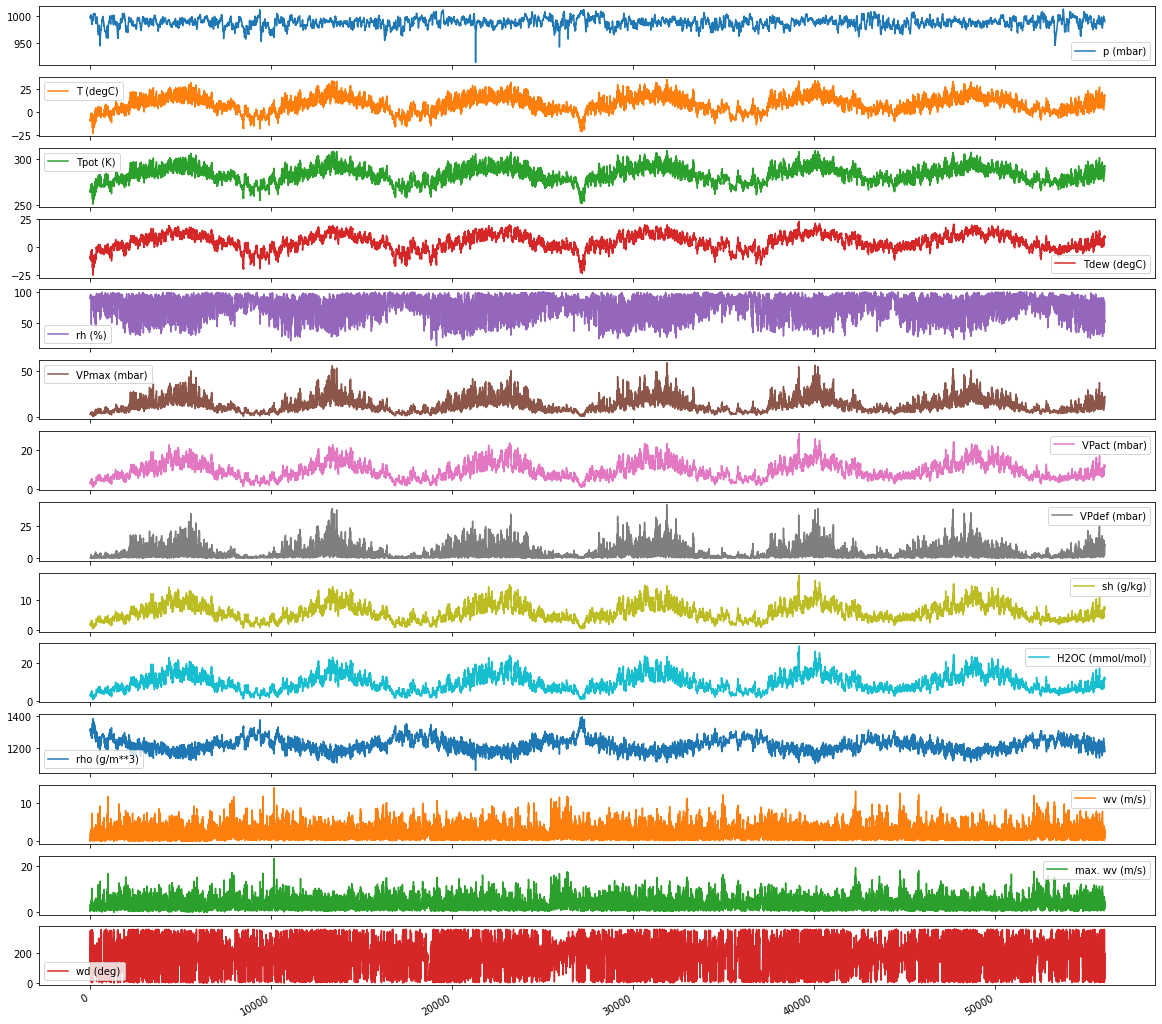

In [112]:
# before normalization plot the data
train_df.plot(subplots=True, figsize=(20, 20))


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

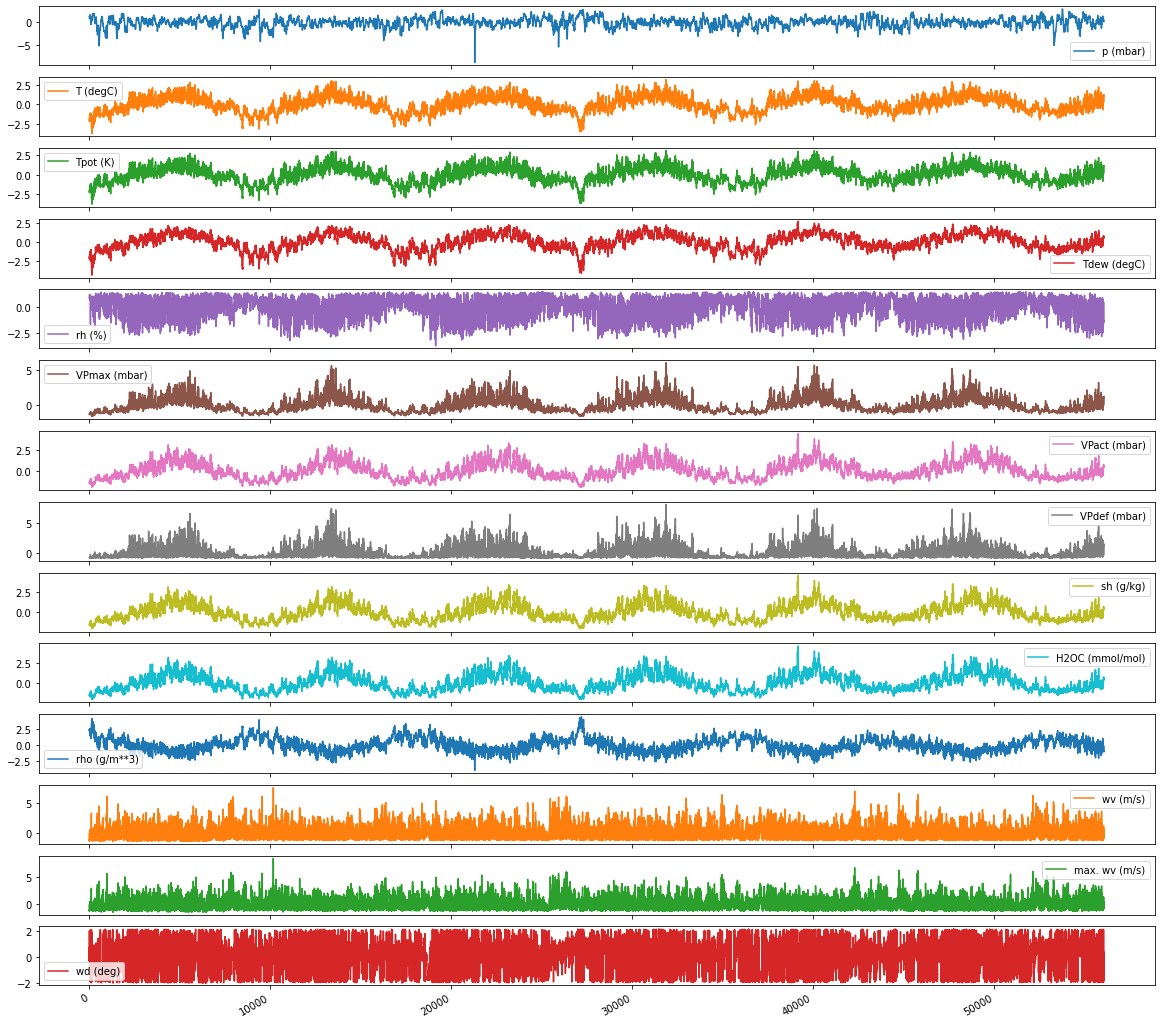

In [113]:
# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# after normalization plot the data
train_df.plot(subplots=True, figsize=(20, 20))




### Visualize the data

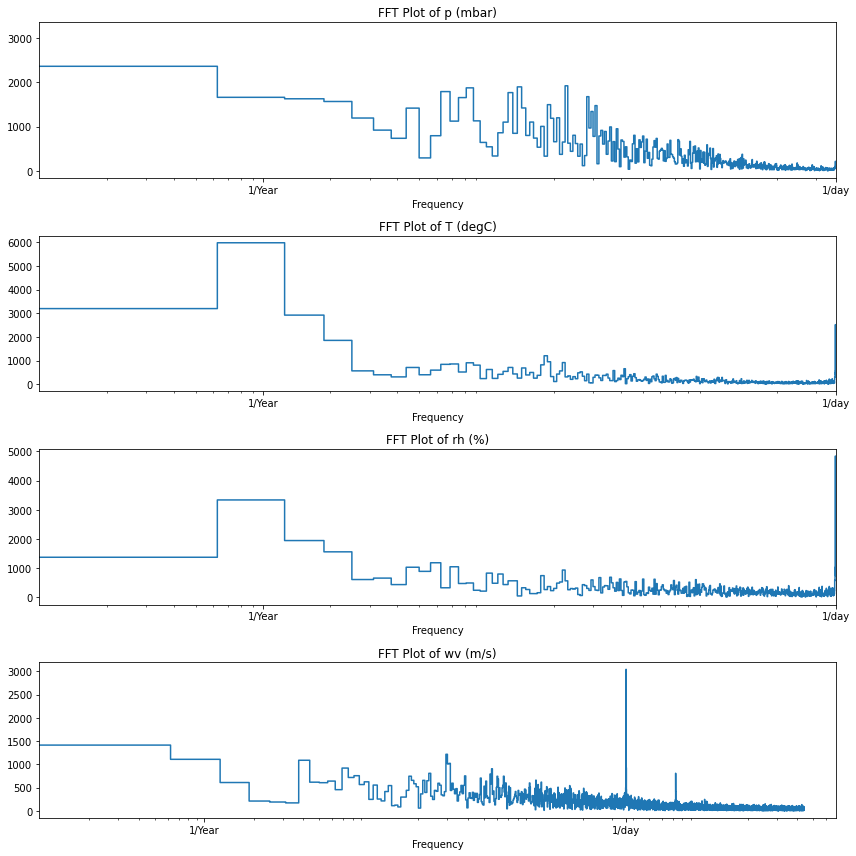

In [159]:
# Reference : https://realpython.com/python-scipy-fft/

# Set the figure size for all plots
plt.rcParams['figure.figsize'] = [12, 12]

# Define the list of features to plot
features_to_plot = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']

# Create the subplots
fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1)

# Loop over each feature and plot its FFT
for i, feature_name in enumerate(features_to_plot):
    
    # Calculate the FFT for the feature data
    feature_data = test_df[feature_name].to_numpy()
    fft = scipy.fft.rfft(feature_data)
    
    # Calculate the frequency axis for the FFT plot
    n_samples = len(feature_data)
    hours_per_year = 24 * 365.2524
    years_per_dataset = n_samples / hours_per_year
    freq_per_dataset = np.arange(0, len(fft))
    freq_per_year = freq_per_dataset / years_per_dataset
    
    # Create the FFT plot
    axes[i].step(freq_per_year, np.abs(fft))
    axes[i].set_xscale('log')
    axes[i].set_xlim([0.1, max(plt.xlim())])
    axes[i].set_xticks([1, 365.2524])
    axes[i].set_xticklabels(['1/Year', '1/day'])
    axes[i].set_xlabel('Frequency')
    axes[i].set_title('FFT Plot of ' + feature_name)

# Adjust the spacing between subplots
fig.tight_layout()

# Show all the plots
plt.show()



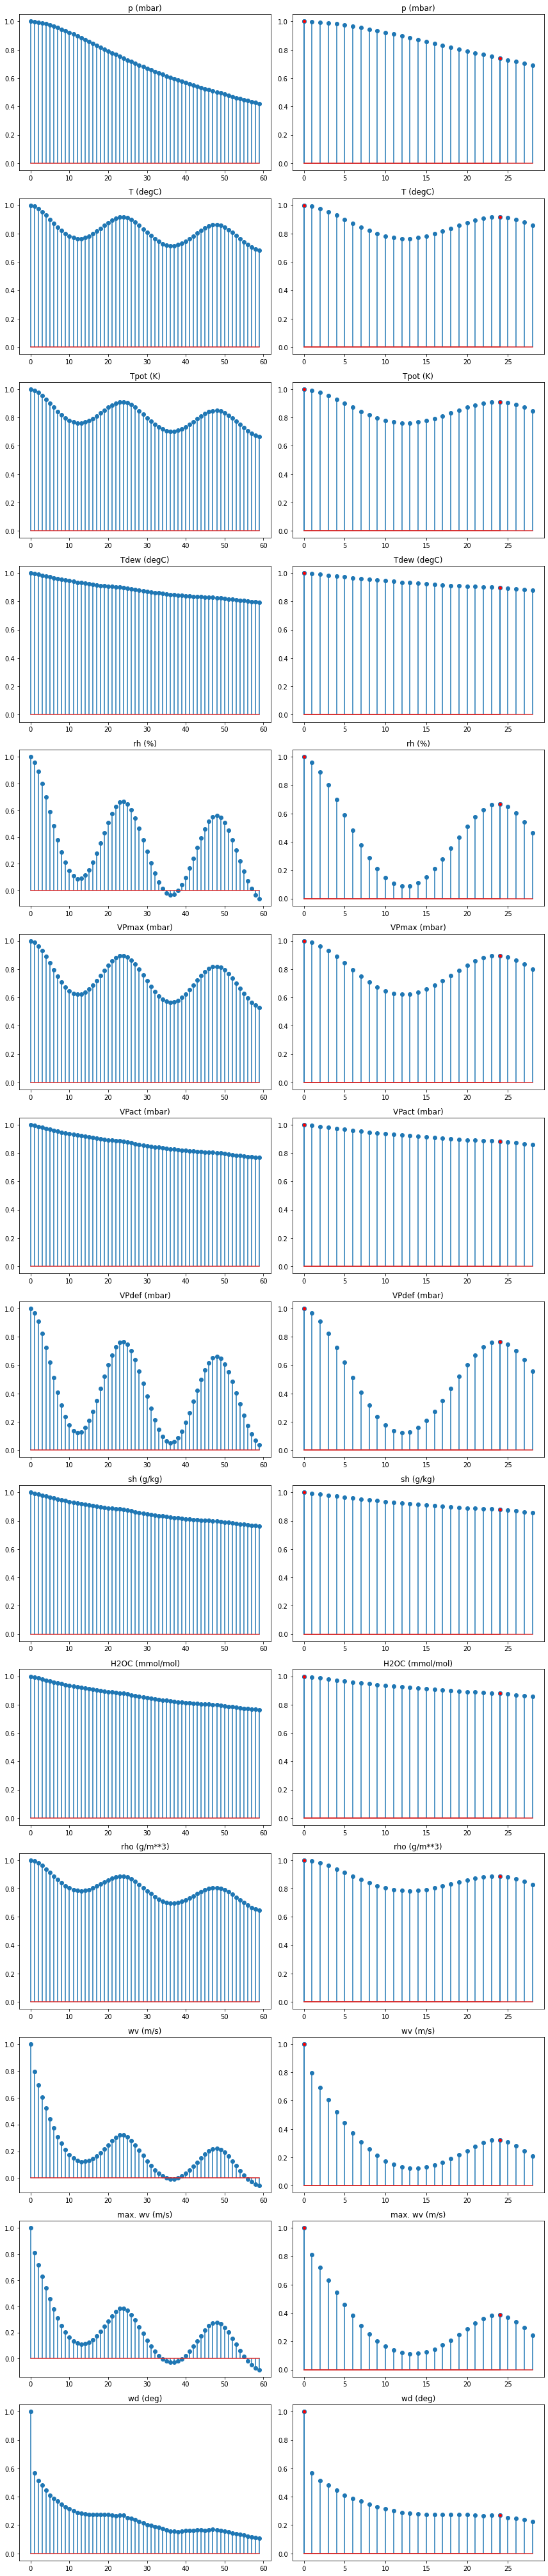

In [160]:
period = 24
lags = list(range(0, 60))
n_features = len(train_df.columns)  # don't get the first feature as that is just the time stamp

fig, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(12, n_features * 4))

for i, feature in enumerate(train_df.columns):
    series_data = train_df[feature]
    autocorr = []
    for lag in lags:
        autocorr.append(series_data.autocorr(lag=lag))

    axes[i][0].stem(lags, autocorr)
    axes[i][0].set_title(feature)

    axes[i][1].stem(lags[0:period+5], autocorr[0:period+5])
    markerline, stemlines, baseline = axes[i][1].stem([lags[0], lags[period]], [autocorr[0], autocorr[period]])
    markerline.set_markerfacecolor('red')
    axes[i][1].set_title(feature)

plt.tight_layout()
plt.show()


<AxesSubplot:>

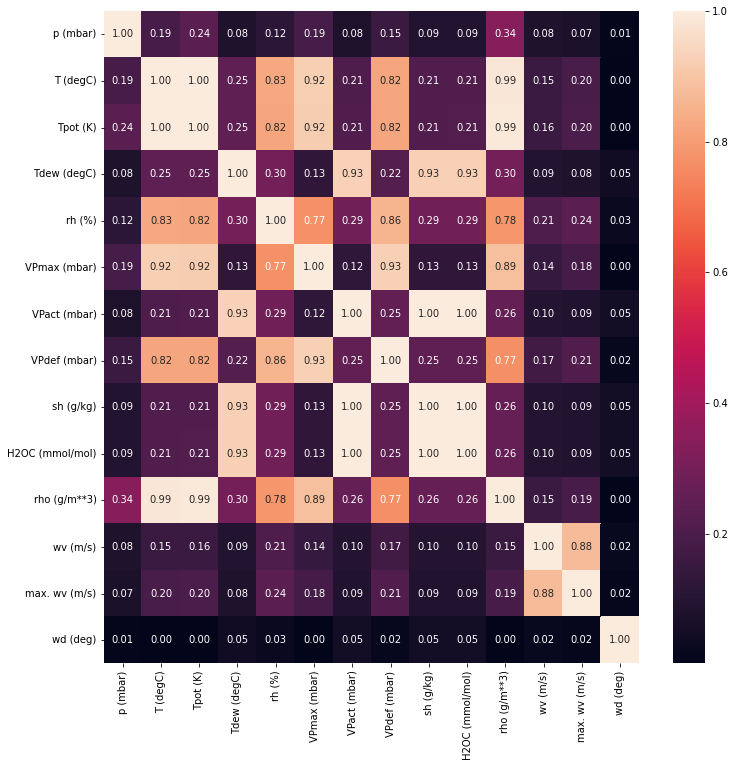

In [161]:
# pearson correlation heatmap
# make a copy of the data
train_df_copy = train_df.copy()
for x,y in train_df_copy.iteritems(): # iterate over columns
    train_df_copy[x] = (train_df_copy[x] - train_df_copy[x].shift(1)).fillna(0) # shift the data by 1 and fill the first row with 0
# plt.rcParams['figure.figsize'] = [20, 20]
# plot absolute value of correlation matrix
sns.heatmap(train_df_copy.corr().abs(), annot=True, fmt=".2f")


In [116]:
def extract_sliding_windows(data, seq_length, input_columns=None, output_columns=None):
    """
    Extract sliding windows of input and output data from a dataset.
    
    Args:
        data (pandas.DataFrame): The input dataset.
        seq_length (int): The length of each sliding window.
        input_columns (list of str, optional): The names of the input columns in the dataset.
        output_columns (list of str, optional): The names of the output columns in the dataset.
    
    Returns:
        inputs (torch.Tensor): A tensor containing the input windows.
        outputs (torch.Tensor): A tensor containing the corresponding output values.
    """
    inputs = []
    outputs = []
    
    # Select the input and output columns from the dataset
    if input_columns is not None:
        input_data = data[input_columns]
    else:
        input_data = data
        
    if output_columns is not None:
        output_data = data[output_columns]
    else:
        output_data = data.iloc[:, -1]
    
    # Loop over the dataset and extract sliding windows
    for i in range(len(data) - seq_length):
        input_window = input_data.iloc[i:i+seq_length]
        output_window = output_data.iloc[i+seq_length]
        
        inputs.append(input_window.values)
        outputs.append(output_window)
        
    # Convert the inputs and outputs to PyTorch tensors
    inputs = torch.Tensor(inputs).to(device)
    outputs = torch.Tensor(outputs).to(device)
    
    return inputs, outputs

def error_propagation(model, test_feature_data, test_label_data, time, k, criterion):
    """
    Computes the error propagation for a given PyTorch model and test data.

    Args:
        model (nn.Module): A PyTorch model object.
        test_feature_data (torch.Tensor): A tensor containing the test feature data.
        test_label_data (torch.Tensor): A tensor containing the test label data.
        time (int): The starting time step for the error propagation.
        k (int): The number of time steps to propagate the error forward.
        criterion (nn.Module): The loss criterion to use for computing the loss.

    Returns:
        A tuple containing the following:
            - A list of loss values for each time step.
            - A list of time steps.
            - A tensor containing the predicted label data.
    """
    loss_list = []
    time_list = []
    pred_label_data = test_label_data.clone().detach()

    model.eval()
    with torch.no_grad():
        for t in range(time, time+k+1):
            # Select features from t-k to t
            feature_data = test_feature_data[t-k:t]

            # Reshape the feature data to size (batch_size=1, k, feature_number)
            feature_data = torch.unsqueeze(feature_data, dim=0)

            # Get the true label at time t
            true_label_data = test_label_data[t, :]

            # Get the predicted label using the model
            pred_label = model(feature_data)

            # Update the predicted label at time t to achieve error propagation
            pred_label_data[t, :] = pred_label

            # Calculate the loss between the predicted and true label
            loss = criterion(pred_label, true_label_data)

            print(f"@ Time step: {t}, Predicted value: {pred_label}, True Label: {true_label_data}")

            loss_list.append(loss.item())
            time_list.append(t)

    data_time = []
    for i in time_list: 
        data_time.append(test_date_time[i])
    # Plot the predicted and true labels
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data_time, loss_list, 'o-', linewidth=0.5)
    ax.set_xticks(data_time)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.set_xlabel('Time')
    ax.set_ylabel('MSE')
    ax.set_title('Error Propagation')
    plt.show()

    return loss_list, time_list, pred_label_data

def plot_errors(losses, time_steps):
    """
    Plot the errors for a given error propagation.
    
    Args:
        losses (list): A list of the losses for each time step in the error propagation.
        time_steps (list): A list of the time steps for the error propagation.
    """
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.plot(time_steps, losses)
    plt.xlabel('Time step')
    plt.ylabel('Loss')
    plt.show()

def get_true_values(test_labels, start_time, num_steps, output_columns=None):
    """
    Get the true values from the test data.
    
    Args:
        test_labels (torch.Tensor): The label data for the test set.
        start_time (int): The starting time step for error propagation.
        num_steps (int): The number of steps to propagate the errors for.
        output_columns (list of str, optional): The names of the output columns in the dataset.
        
    Returns:
        true_values (list): A list of the true values for the given time steps.
    """
    # Select the output columns from the test labels
    if output_columns is not None:
        true_values = test_labels[start_time:start_time+num_steps, output_columns].numpy()
    else:
        true_values = test_labels[start_time:start_time+num_steps, -1].numpy()
        
    return true_values

def get_predictions(model, test_features, test_labels, start_time, num_steps, input_columns=None, output_columns=None):
    """
    Get the predictions from a given model.
    
    Args:
        model (torch.nn.Module): The PyTorch model to use for prediction.
        test_features (torch.Tensor): The feature data for the test set.
        test_labels (torch.Tensor): The label data for the test set.
        start_time (int): The starting time step for error propagation.
        num_steps (int): The number of steps to propagate the errors for.
        input_columns (list of str, optional): The names of the input columns in the dataset.
        output_columns (list of str, optional): The names of the output columns in the dataset.
    
    Returns:
        predictions (list): A list of the predictions for the given time steps.
    """

    # Get the predictions from the model
    predictions = []
    model.eval()
    with torch.no_grad():
        for t in range(start_time, start_time + num_steps):

            # Get the feature data for the current time step
            features = test_features[t - num_steps : t]

            # Reshape the feature data to match the model's input format
            features = features.unsqueeze(0)

            # Use the model to make a prediction
            predictions.append(model(features).item())

    # Get the true values from the test data
    true_values = get_true_values(test_labels, start_time, num_steps, output_columns)

    return predictions, true_values

# def plot_predictions(model, test_features, test_labels, start_time, num_steps, input_columns=None, output_columns=None):

#     # Get the predictions from the model
#     predictions = get_predictions(model, test_features, test_labels, start_time, num_steps, input_columns, output_columns)

#     # Get the true values from the test data
#     true_values = get_true_values(test_labels, start_time, num_steps, output_columns)

#     # Plot the predictions and true values
#     plt.rcParams['figure.figsize'] = [8, 4]
#     plt.plot(predictions, label='Predictions')
#     plt.plot(true_values, label='True values')
#     plt.xlabel('Time step')
#     plt.ylabel('CO2 concentration (ppm)')
#     plt.legend()
#     plt.show()

# Define the feature columns
p_features = ['p (mbar)', 'T (degC)', 'VPmax (mbar)', 'rho (g/m**3)']
T_features = ['T (degC)', 'rh (%)', 'VPmax (mbar)', 'VPdef (mbar)', 'rho (g/m**3)']
rh_features = ['rh (%)', 'T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'rho (g/m**3)']
wv_features = ['wv (m/s)', 'max. wv (m/s)', 'rh (%)']
feature_columns = list(set().union(p_features, T_features, rh_features, wv_features))
print('Input features:', feature_columns)

# Define the label columns
label_columns = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']
print('Labels:', label_columns)

# Define the sliding window size, batch size
k = 4
batch_size = 32

# Create the training feature and label datasets
train_feature, train_label = extract_sliding_windows(train_df, seq_length=k, input_columns=feature_columns, output_columns=label_columns)
train_feature = DataLoader(train_feature, batch_size=batch_size, shuffle=False, drop_last=True)
train_label = DataLoader(train_label, batch_size=batch_size, shuffle=False, drop_last=True)

# Create the test feature and label datasets
test_feature, test_label = extract_sliding_windows(test_df, seq_length=k, input_columns=feature_columns, output_columns=label_columns)
test_feature = DataLoader(test_feature, batch_size=batch_size, shuffle=False, drop_last=True)
test_label = DataLoader(test_label, batch_size=batch_size, shuffle=False, drop_last=True)

test_feature_data_tensor = torch.Tensor(np.array(test_df[feature_columns])).to(device)
test_label_data_tensor = torch.Tensor(np.array(test_df[label_columns])).to(device)
test_pred_label_data_tensor = torch.Tensor(np.array(test_df[label_columns])).to(device)




Input features: ['T (degC)', 'p (mbar)', 'max. wv (m/s)', 'rho (g/m**3)', 'wv (m/s)', 'VPdef (mbar)', 'VPmax (mbar)', 'rh (%)']
Labels: ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']


In [185]:
# ****************************************************************************
# Model 1
# ****************************************************************************
## a baseline model consisting of only fully-connected (nn.Linear) layers

# define the modele 1 class
class Model1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.mean(x, dim=1)
        return x
# ****************************************************************************
# Model 2
# ****************************************************************************
# a baseline model that uses at least one layer of LSTM

# define the model 2 class
class SingleOutputLSTM(nn.LSTM):
    def forward(self, x):
        output, _ = super().forward(x)
        return output

class Model2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model2, self).__init__()
        self.lstm = SingleOutputLSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# ****************************************************************************
# Model 3
# ****************************************************************************
# your own model (may use any neural network, including but not limited to CNNs and GRUs)

# define the model 3 class
class Model3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model3, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.gru(x)
        x = self.fc(hn[-1])
        return x


In [163]:
# train the model
def train_model(model, train_feature, train_label, test_feature, test_label, num_epochs, learning_rate, criterion, optimizer):
    """
    Helper function to train the model

    Args:
        model: the model to train
        train_feature: the training feature dataset
        train_label: the training label dataset
        test_feature: the test feature dataset
        test_label: the test label dataset
        num_epochs: the number of epochs to train the model
        learning_rate: the learning rate to use for the optimizer
        criterion: the loss function to use
        optimizer: the optimizer to use

    Returns:
        train_losses: the training losses
        test_losses: the test losses
    """

    # step 1: initialize the model
    model = model.to(device)

    # step 2: initialize the optimizer
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    # step 3: initialize the loss function
    criterion = criterion

    # step 4: initialize the lists to store the training and test losses
    train_losses = []
    test_losses = []

    # step 5: train the model
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        # initialize the training loss
        train_loss = 0
        # loop over the training dataset
        for i, (feature, label) in enumerate(zip(train_feature, train_label)):
            # move the feature and label to the device
            feature = feature.to(device)
            label = label.to(device)
            # zero the gradients
            optimizer.zero_grad()
            # forward pass
            output = model(feature)
            # calculate the loss
            loss = criterion(output, label)
            # backward pass
            loss.backward()
            # update the weights
            optimizer.step()
            # update the training loss
            train_loss += loss.item()

        # set the model to evaluation mode
        model.eval()
        # initialize the test loss
        test_loss = 0
        # loop over the test dataset
        for i, (feature, label) in enumerate(zip(test_feature, test_label)):
            # move the feature and label to the device
            feature = feature.to(device)
            label = label.to(device)
            # forward pass
            output = model(feature)
            # calculate the loss
            loss = criterion(output, label)
            # update the test loss
            test_loss += loss.item()

        # calculate the average training and test losses
        train_loss = train_loss / len(train_feature)
        test_loss = test_loss / len(test_feature)

        # append the training and test losses
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # print the training and test losses
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses





In [178]:
# mape function
def mape1(model, test_feature, test_label):
    """
    Helper function to calculate the MAPE

    Args:
        model: the model to train
        test_feature: the test feature dataset
        test_label: the test label dataset

    Returns:
        mape: the mean absolute percentage error
    """

    # set the model to evaluation mode
    model.eval()

    # initialize the list to store the absolute percentage errors
    ape = []

    # loop over the test dataset
    for feature, label in zip(test_feature, test_label):
        feature = feature.to(device)
        label = label.to(device)
        # forward pass
        output = model(feature)
        # calculate the absolute percentage error
        ape.append(torch.mean(torch.abs((label - output) / label)))

    # calculate the mean absolute percentage error
    mape = torch.mean(torch.Tensor(ape))

    return mape

def wmape1(model, test_feature, test_label):
    """
    Helper function to calculate the WMAPE
    Args:
    model: the model to train
    test_feature: the test feature dataset
    test_label: the test label dataset

    Returns:
        wmape: the weighted mean absolute percentage error
    """

    # set the model to evaluation mode
    model.eval()

    # initialize the sum of absolute percentage errors and the sum of true values
    ape_sum = 0
    true_sum = 0

    # loop over the test dataset
    for feature, label in zip(test_feature, test_label):
        feature = feature.to(device)
        label = label.to(device)
        # forward pass
        output = model(feature)
        # calculate the absolute percentage error
        ape = torch.abs((label - output) / label)
        # add the sum of absolute percentage errors and the sum of true values
        ape_sum += torch.sum(ape)
        true_sum += torch.sum(label)

    # calculate the weighted mean absolute percentage error
    wmape = ape_sum / true_sum

    return wmape

def calculate_mse(predict, label, train_mean, train_std):
    """
    Helper function to calculate the MSE

    Args:
        predict: the predicted values
        label: the label values
        train_mean: the mean of the training dataset
        train_std: the standard deviation of the training dataset

    Returns:
        mse_dict: a dictionary containing the MSE for each label column
    """
    # Flatten the predict and label lists
    predict_flat = [item.item() for sublist in predict for item in sublist]
    label_flat = [item.item() for sublist in label for item in sublist]

    # Initialize a dictionary to store the MSE for each label column
    mse_dict = {}

    # Loop over the label columns
    for col in range(len(train_mean)):
        # Extract the predicted and label values for the current label column
        predict_values = np.array([predict_flat[i + col] for i in range(0, len(predict_flat), len(train_mean))])
        label_values = np.array([label_flat[i + col] for i in range(0, len(label_flat), len(train_mean))])

        # Reshape the predicted and label values
        predict_values = predict_values.reshape(-1, 1)
        label_values = label_values.reshape(-1, 1)

        # Reverse the normalization
        predict_values = predict_values * train_std[col] + train_mean[col]
        label_values = label_values * train_std[col] + train_mean[col]

        # Calculate the mean squared error

        mse = np.mean(np.square(label_values - predict_values))
        # Only print MSE for p (mbar), T (degC), rh (%), and wv (m/s)
        if col < len(label_columns) and label_columns[col] in ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']:
            print(f'MSE for {label_columns[col]}: {mse:.4f}')
        mse_dict[label_columns[col]] = mse

    return mse_dict

In [166]:
# train the model 1
model1 = Model1(input_size=len(feature_columns), hidden_size=64, output_size=len(label_columns)).to(device)
# summarize the model
print(model1)
print(batch_size)
summary(model1,(4, 8), batch_size)
train_losses1, test_losses1 = train_model(model1, train_feature, train_label, test_feature, test_label, num_epochs=20, learning_rate=0.001, criterion=nn.MSELoss(), optimizer=optim.Adam)

# calculate the mape for model 1
mape_value = mape1(model1, test_feature, test_label)

# print the mape for model 1
print(f'MAPE: {mape_value:.4f}')

# calculate the wmape for model 1
wmape_value = wmape1(model1, test_feature, test_label)
print(f'WMAPE: {wmape_value:.4f}')

Model1(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)
32
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [32, 4, 64]             576
            Linear-2                 [32, 4, 4]             260
Total params: 836
Trainable params: 836
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.07
----------------------------------------------------------------
Epoch 1/20, Training Loss: 0.2479, Test Loss: 0.1959
Epoch 2/20, Training Loss: 0.1920, Test Loss: 0.1970
Epoch 3/20, Training Loss: 0.1907, Test Loss: 0.1962
Epoch 4/20, Training Loss: 0.1897, Test Loss: 0.1954
Epoch 5/20, Training Loss: 0.1889, Test Loss: 0.1948
Epoch 6/20, Training Loss: 0.1881, Tes

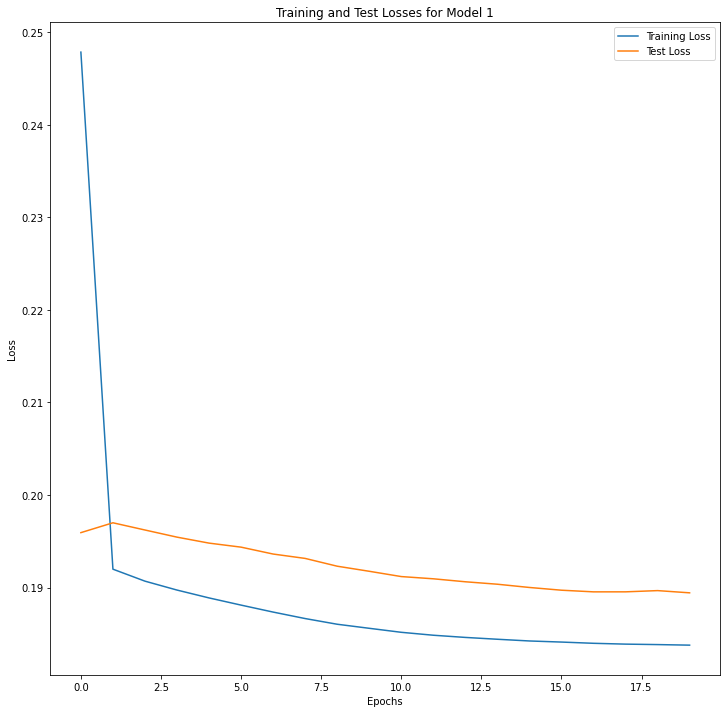

In [170]:
# plot the training and test losses
plt.plot(train_losses1, label='Training Loss')
plt.plot(test_losses1, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses for Model 1')
plt.legend()
plt.show()



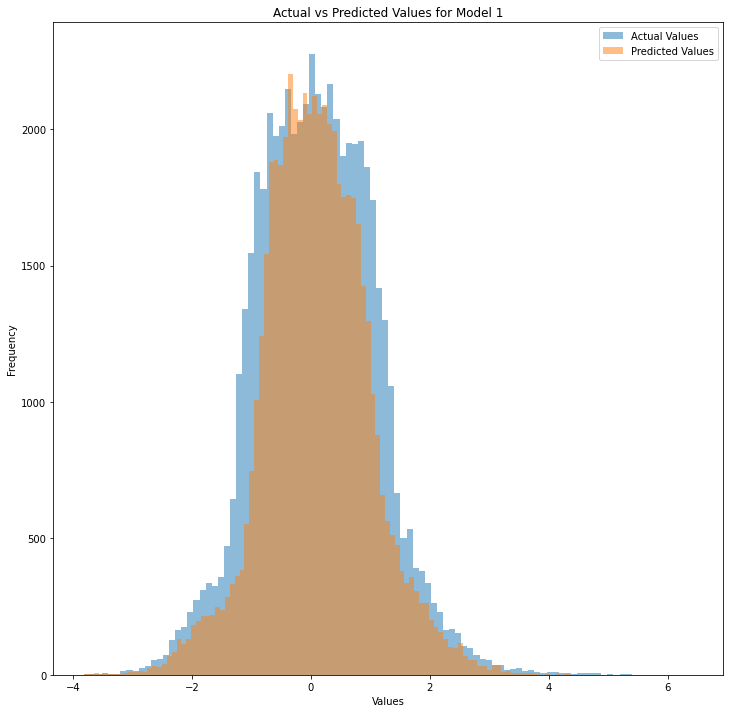

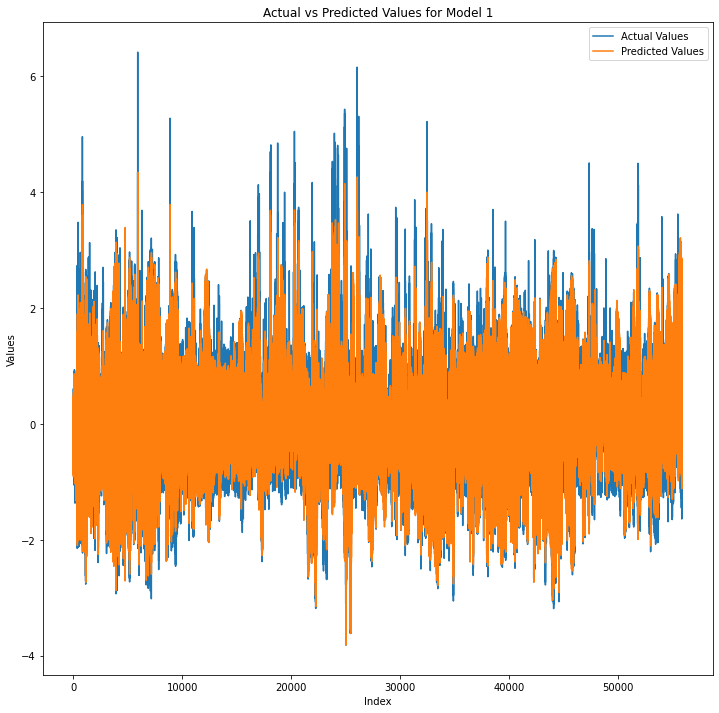

In [173]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the model to evaluation mode
model1.eval()

# Initialize the list to store the actual and predicted values
actual_values = []
predicted_values = []

# Loop over the test data and make predictions
with torch.no_grad():
    for feature, label in zip(test_feature, test_label):
        # Move the feature and label to the device
        feature = feature.to(device)
        label = label.to(device)
        # Make predictions
        output = model1(feature)
        # Unroll the label and output into a single array
        label = label.view(-1).cpu().detach().numpy()
        output = output.view(-1).cpu().detach().numpy()
        # Append the actual and predicted values to the list
        actual_values.append(label)
        predicted_values.append(output)
        

# Concatenate the actual and predicted values into arrays
actual_values = np.concatenate(actual_values)
predicted_values = np.concatenate(predicted_values)

# Create a histogram of the actual vs predicted values
fig, ax = plt.subplots()
ax.hist(actual_values, bins=100, alpha=0.5, label='Actual Values')
ax.hist(predicted_values, bins=100, alpha=0.5, label='Predicted Values')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Actual vs Predicted Values for Model 1')
ax.legend()


# line plot of actual vs predicted values
fig, ax = plt.subplots()
ax.plot(actual_values, label='Actual Values')
ax.plot(predicted_values, label='Predicted Values')
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Actual vs Predicted Values for Model 1')
ax.legend()
plt.show()




@ Time step: 3400, Predicted value: tensor([[ 0.3407, -0.7691,  0.4957, -0.0193]], device='cuda:0'), True Label: tensor([ 0.3422, -0.7911,  0.3753,  0.4994], device='cuda:0')
@ Time step: 3401, Predicted value: tensor([[ 0.3516, -0.7515,  0.4354,  0.0577]], device='cuda:0'), True Label: tensor([ 0.3446, -0.7117,  0.2541,  0.1817], device='cuda:0')
@ Time step: 3402, Predicted value: tensor([[ 0.3667, -0.7248,  0.3565,  0.1392]], device='cuda:0'), True Label: tensor([ 0.3002, -0.6975,  0.2904,  0.7523], device='cuda:0')
@ Time step: 3403, Predicted value: tensor([[ 0.3670, -0.6999,  0.2948,  0.3081]], device='cuda:0'), True Label: tensor([ 0.3134, -0.6821,  0.2541,  0.8950], device='cuda:0')
@ Time step: 3404, Predicted value: tensor([[ 0.3683, -0.6839,  0.2498,  0.4335]], device='cuda:0'), True Label: tensor([ 0.2871, -0.6750,  0.2541,  0.4411], device='cuda:0')
@ Time step: 3405, Predicted value: tensor([[ 0.3636, -0.6488,  0.1816,  0.4414]], device='cuda:0'), True Label: tensor([ 0.2

/home/gauri/Trustworthy/fairness/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


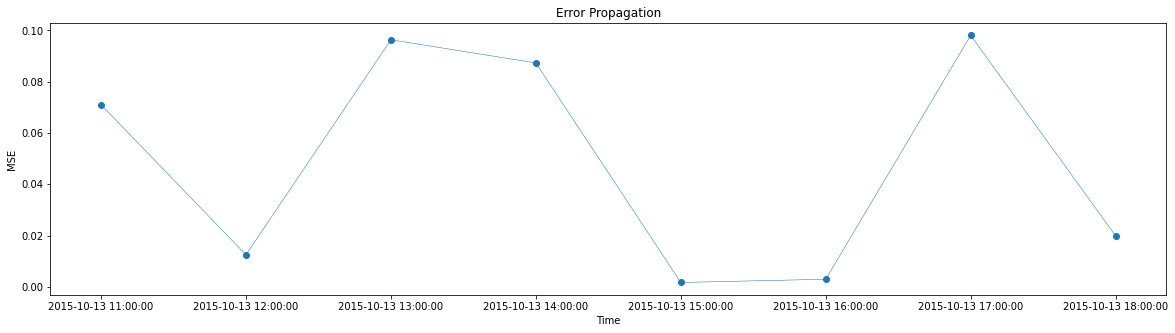

Error Propagation MSE: 0.04872775651165284


In [174]:
# error propagation function
test_feature_data =  torch.Tensor(np.array(test_df[feature_columns])).to(device)
test_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
test_pred_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
criteria = nn.MSELoss()
loss_list, time_list, pred_label_data = error_propagation(model1, test_feature_data, test_label_data, time=3400, k=7, criterion=criteria)
print('Error Propagation MSE:', np.mean(loss_list))
# # calculate_mse(pred_label_data, test_label_data, train_mean, train_std)


In [186]:
# train the model 2
model2 = Model2(input_size=len(feature_columns), hidden_size=64, output_size=len(label_columns)).to(device)
# summarize the model
print(model2)
summary(model2,(4, 8), batch_size)
# summary(model2 , (batch_size, len(feature_columns)))
train_losses2, test_losses2 = train_model(model2, train_feature, train_label, test_feature, test_label, num_epochs=20, learning_rate=0.001, criterion=nn.MSELoss(), optimizer=optim.Adam)

Model2(
  (lstm): SingleOutputLSTM(8, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  SingleOutputLSTM-1                [32, 4, 64]               0
            Linear-2                    [32, 4]             260
Total params: 260
Trainable params: 260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.07
----------------------------------------------------------------
Epoch 1/20, Training Loss: 0.1751, Test Loss: 0.1072
Epoch 2/20, Training Loss: 0.1049, Test Loss: 0.1005
Epoch 3/20, Training Loss: 0.1021, Test Loss: 0.0980
Epoch 4/20, Training Loss: 0.1006, Test Loss: 0.0972
Epoch 5/20, Training Loss: 0.0999, Test Loss: 0.0967
Epoch 6/20, Training Loss: 0.0992, Test Loss: 0.0

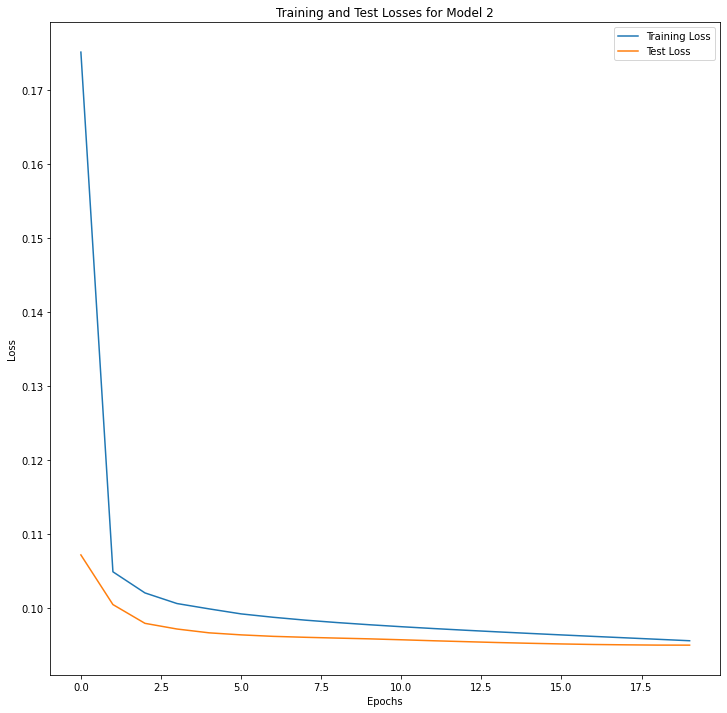

In [189]:
# plot the training and test losses
plt.plot(train_losses2, label='Training Loss')
plt.plot(test_losses2, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses for Model 2')
plt.legend()
plt.show()


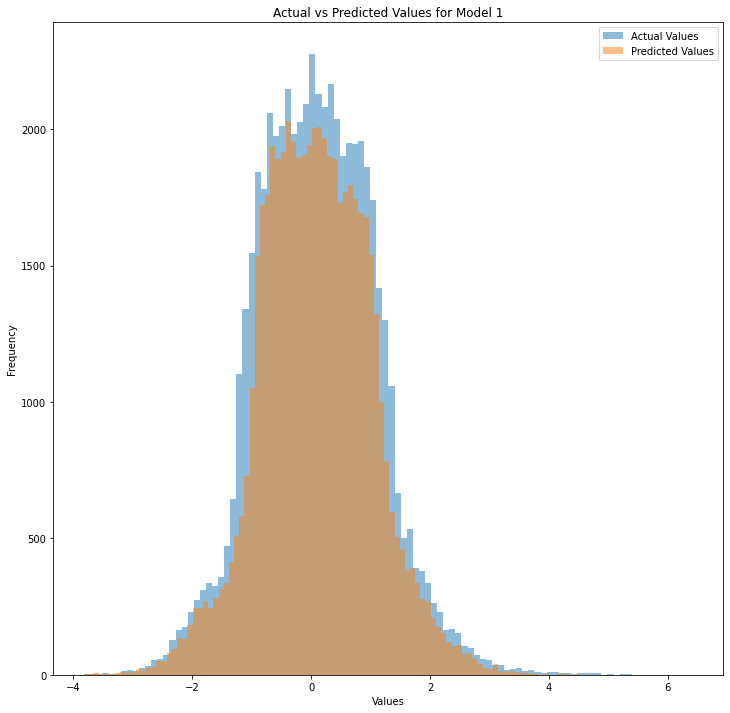

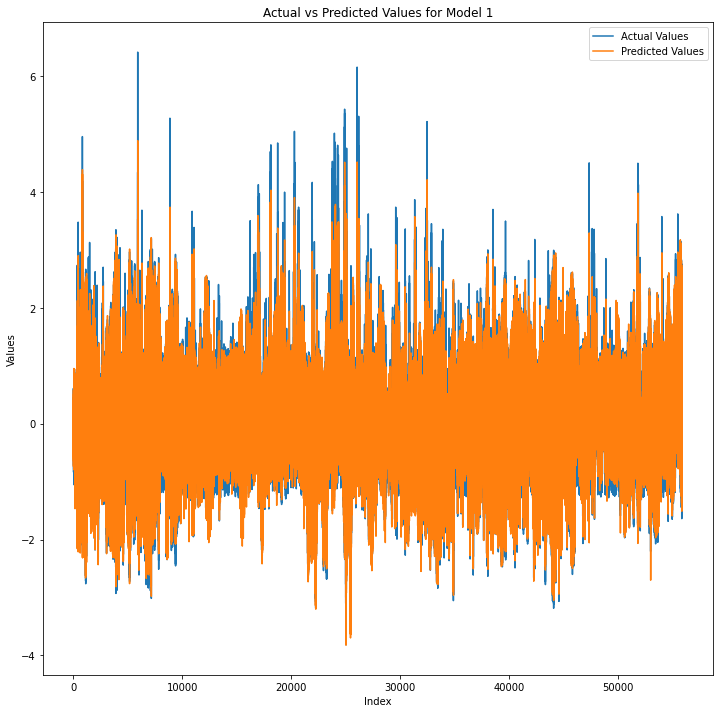

In [190]:
from sklearn.metrics import mean_squared_error
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the model to evaluation mode
model2.eval()

# Initialize the list to store the actual and predicted values
actual_values = []
predicted_values = []

# Loop over the test data and make predictions
with torch.no_grad():
    for feature, label in zip(test_feature, test_label):
        # Move the feature and label to the device
        feature = feature.to(device)
        label = label.to(device)
        # Make predictions
        output = model2(feature)
        # Unroll the label and output into a single array
        label = label.view(-1).cpu().detach().numpy()
        output = output.view(-1).cpu().detach().numpy()
        # Append the actual and predicted values to the list
        actual_values.append(label)
        predicted_values.append(output)
        

# Concatenate the actual and predicted values into arrays
actual_values = np.concatenate(actual_values)
predicted_values = np.concatenate(predicted_values)

# Create a histogram of the actual vs predicted values
fig, ax = plt.subplots()
ax.hist(actual_values, bins=100, alpha=0.5, label='Actual Values')
ax.hist(predicted_values, bins=100, alpha=0.5, label='Predicted Values')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Actual vs Predicted Values for Model 2')
ax.legend()


# line plot of actual vs predicted values
fig, ax = plt.subplots()
ax.plot(actual_values, label='Actual Values')
ax.plot(predicted_values, label='Predicted Values')
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Actual vs Predicted Values for Model 2')
ax.legend()
plt.show()




In [199]:
# calculate the mape for model 1
mape_value = mape1(model2, test_feature, test_label)

# print the mape for model 1
print(f'MAPE: {mape_value:.4f}')

# calculate the wmape for model 1
wmape_value = wmape1(model3, test_feature, test_label)
print(f'WMAPE: {wmape_value:.4f}')

MAPE: 3.4571
WMAPE: 36.4757


@ Time step: 3400, Predicted value: tensor([[ 0.4031, -0.8745,  0.4354,  0.2387]], device='cuda:0'), True Label: tensor([ 0.3422, -0.7911,  0.3753,  0.4994], device='cuda:0')
@ Time step: 3401, Predicted value: tensor([[ 0.3686, -0.7504,  0.1912,  0.3977]], device='cuda:0'), True Label: tensor([ 0.3446, -0.7117,  0.2541,  0.1817], device='cuda:0')
@ Time step: 3402, Predicted value: tensor([[ 0.3823, -0.6801,  0.0908,  0.2429]], device='cuda:0'), True Label: tensor([ 0.3002, -0.6975,  0.2904,  0.7523], device='cuda:0')
@ Time step: 3403, Predicted value: tensor([[ 0.2997, -0.7109,  0.2385,  0.4905]], device='cuda:0'), True Label: tensor([ 0.3134, -0.6821,  0.2541,  0.8950], device='cuda:0')
@ Time step: 3404, Predicted value: tensor([[ 0.3626, -0.6876,  0.2057,  0.5549]], device='cuda:0'), True Label: tensor([ 0.2871, -0.6750,  0.2541,  0.4411], device='cuda:0')
@ Time step: 3405, Predicted value: tensor([[ 0.3013, -0.6930,  0.1961,  0.4398]], device='cuda:0'), True Label: tensor([ 0.2

/home/gauri/Trustworthy/fairness/lib/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


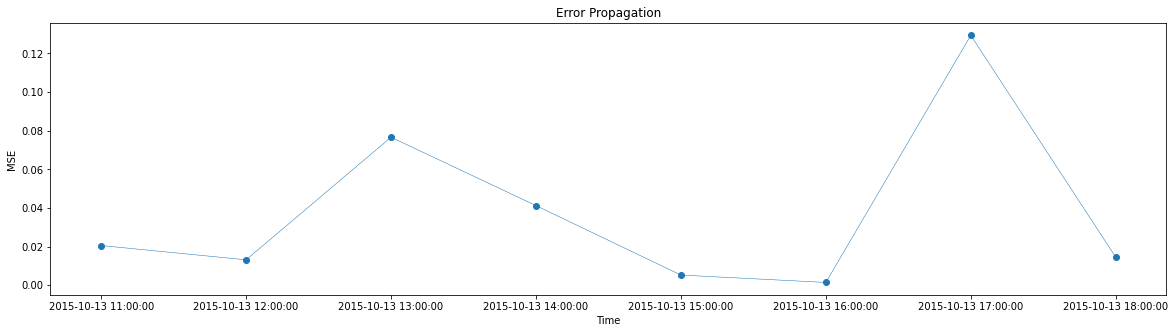

Error Propagation MSE: 0.03777689827256836


In [192]:
# error propagation function
test_feature_data =  torch.Tensor(np.array(test_df[feature_columns])).to(device)
test_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
test_pred_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
criteria = nn.MSELoss()
loss_list, time_list, pred_label_data = error_propagation(model2, test_feature_data, test_label_data, time=3400, k=7, criterion=criteria)
print('Error Propagation MSE:', np.mean(loss_list))
# # calculate_mse(pred_label_data, test_label_data, train_mean, train_std)

In [195]:
model3 = Model3(input_size=8, hidden_size=64, output_size=len(label_columns)).to(device)
# summarize the model
print(model3)
print(batch_size)
summary(model3,(4, 8), batch_size)
train_losses3, test_losses3 = train_model(model3, train_feature, train_label, test_feature, test_label, num_epochs=20, learning_rate=0.001, criterion=nn.MSELoss(), optimizer=optim.Adam)



Model3(
  (gru): GRU(8, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)
32
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 4, 64], [-1, 2, 64]]               0
            Linear-2                    [32, 4]             260
Total params: 260
Trainable params: 260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.00
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
Epoch 1/20, Training Loss: 0.1519, Test Loss: 0.1031
Epoch 2/20, Training Loss: 0.1042, Test Loss: 0.0990
Epoch 3/20, Training Loss: 0.1020, Test Loss: 0.0981
Epoch 4/20, Training Loss: 0.1009, Test Loss: 0.0978
Epoch 5/20, Training Loss: 0.1002, Test Loss: 0.0974
Epoch 6/20, Training Loss: 0.0996, Test Loss: 0.0970
Epoch 

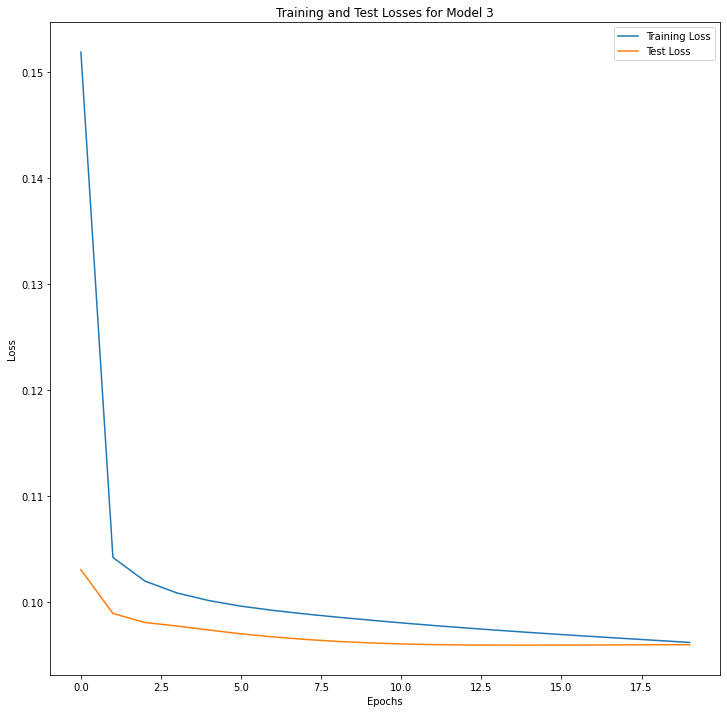

In [196]:
# plot the training and test losses
plt.plot(train_losses3, label='Training Loss')
plt.plot(test_losses3, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses for Model 3')
plt.legend()
plt.show()

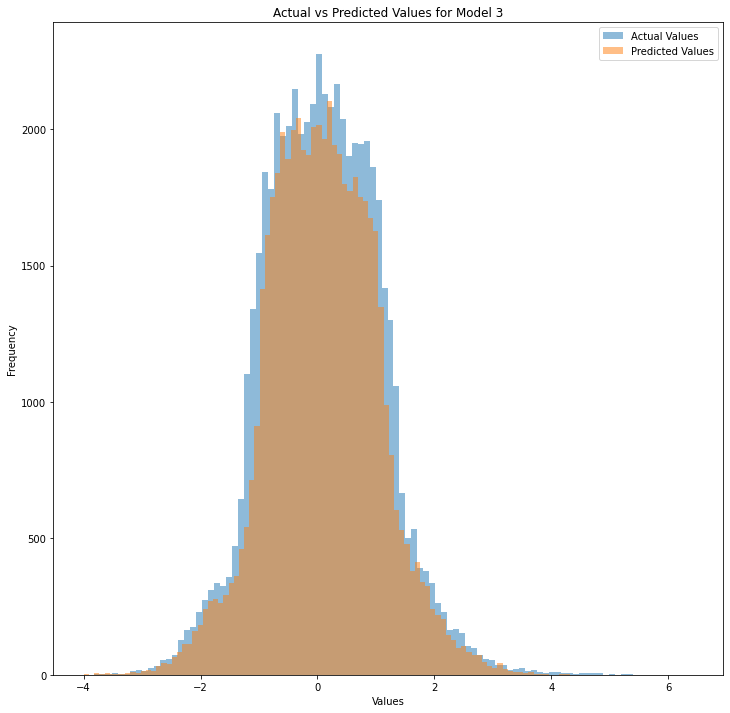

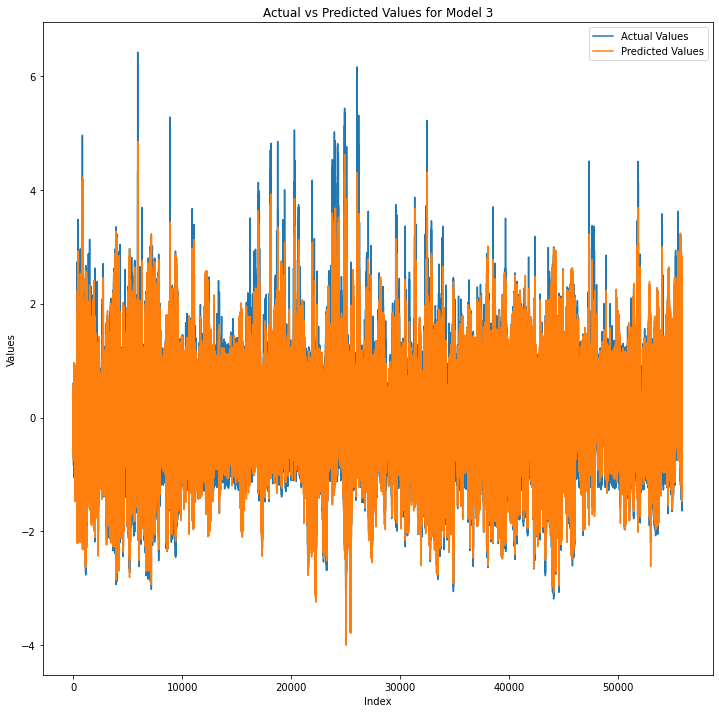

In [197]:
from sklearn.metrics import mean_squared_error
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the model to evaluation mode
model3.eval()

# Initialize the list to store the actual and predicted values
actual_values = []
predicted_values = []

# Loop over the test data and make predictions
with torch.no_grad():
    for feature, label in zip(test_feature, test_label):
        # Move the feature and label to the device
        feature = feature.to(device)
        label = label.to(device)
        # Make predictions
        output = model3(feature)
        # Unroll the label and output into a single array
        label = label.view(-1).cpu().detach().numpy()
        output = output.view(-1).cpu().detach().numpy()
        # Append the actual and predicted values to the list
        actual_values.append(label)
        predicted_values.append(output)
        

# Concatenate the actual and predicted values into arrays
actual_values = np.concatenate(actual_values)
predicted_values = np.concatenate(predicted_values)

# Create a histogram of the actual vs predicted values
fig, ax = plt.subplots()
ax.hist(actual_values, bins=100, alpha=0.5, label='Actual Values')
ax.hist(predicted_values, bins=100, alpha=0.5, label='Predicted Values')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Actual vs Predicted Values for Model 3')
ax.legend()


# line plot of actual vs predicted values
fig, ax = plt.subplots()
ax.plot(actual_values, label='Actual Values')
ax.plot(predicted_values, label='Predicted Values')
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Actual vs Predicted Values for Model 3')
ax.legend()
plt.show()




In [198]:
# calculate the mape for model 1
mape_value = mape1(model3, test_feature, test_label)

# print the mape for model 1
print(f'MAPE: {mape_value:.4f}')

# calculate the wmape for model 1
wmape_value = wmape1(model3, test_feature, test_label)
print(f'WMAPE: {wmape_value:.4f}')

MAPE: 3.4677
WMAPE: 36.4757


@ Time step: 3400, Predicted value: tensor([[ 0.4182, -0.8152,  0.3395,  0.1649]], device='cuda:0'), True Label: tensor([ 0.3422, -0.7911,  0.3753,  0.4994], device='cuda:0')
@ Time step: 3401, Predicted value: tensor([[ 0.3736, -0.7148,  0.1105,  0.3395]], device='cuda:0'), True Label: tensor([ 0.3446, -0.7117,  0.2541,  0.1817], device='cuda:0')
@ Time step: 3402, Predicted value: tensor([[ 0.3934, -0.6463,  0.0559,  0.1664]], device='cuda:0'), True Label: tensor([ 0.3002, -0.6975,  0.2904,  0.7523], device='cuda:0')
@ Time step: 3403, Predicted value: tensor([[ 0.3122, -0.6733,  0.1757,  0.4239]], device='cuda:0'), True Label: tensor([ 0.3134, -0.6821,  0.2541,  0.8950], device='cuda:0')
@ Time step: 3404, Predicted value: tensor([[ 0.3626, -0.6656,  0.1755,  0.5168]], device='cuda:0'), True Label: tensor([ 0.2871, -0.6750,  0.2541,  0.4411], device='cuda:0')
@ Time step: 3405, Predicted value: tensor([[ 0.3112, -0.6665,  0.1761,  0.3936]], device='cuda:0'), True Label: tensor([ 0.2

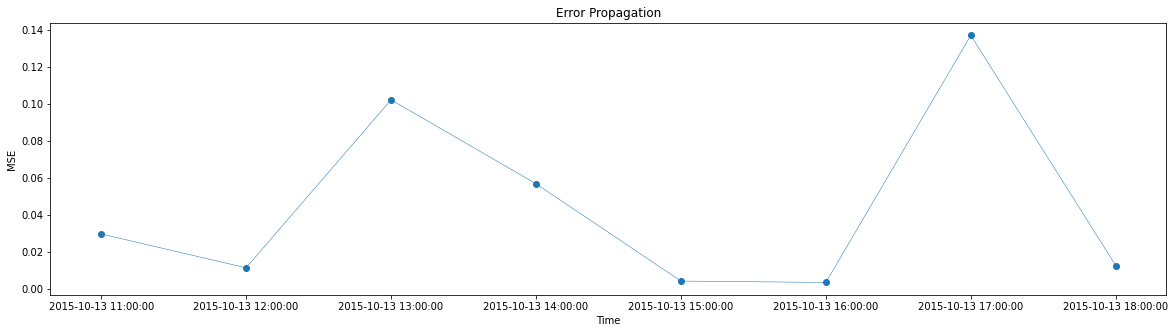

Error Propagation MSE: 0.044885203562444076


In [204]:
# error propagation function
test_feature_data =  torch.Tensor(np.array(test_df[feature_columns])).to(device)
test_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
test_pred_label_data =  torch.Tensor(np.array(test_df[label_columns])).to(device)
criteria = nn.MSELoss()
loss_list, time_list, pred_label_data = error_propagation(model3, test_feature_data, test_label_data, time=3400, k=7, criterion=criteria)
print('Error Propagation MSE:', np.mean(loss_list))
# # calculate_mse(pred_label_data, test_label_data, train_mean, train_std)

### Optional ( Ensemble of 3 models)

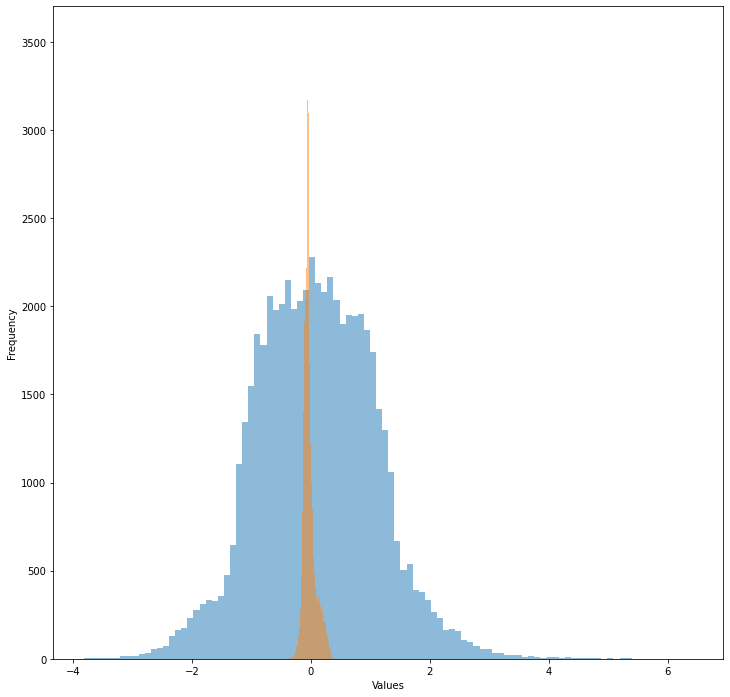

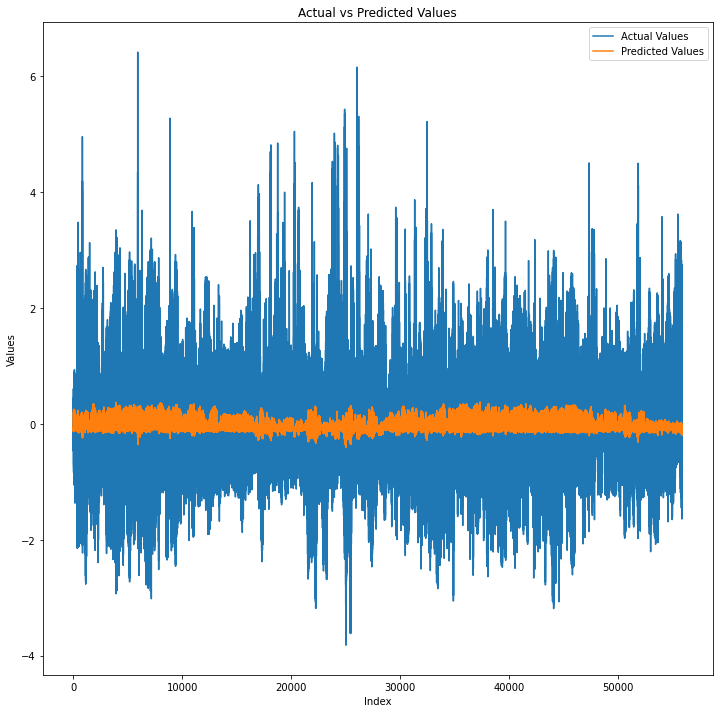

In [206]:
# Define three models
model1 = Model1(input_size=len(feature_columns), hidden_size=64, output_size=len(label_columns)).to(device)
model2 = Model2(input_size=len(feature_columns), hidden_size=64, output_size=len(label_columns)).to(device)
model3 = Model3(input_size=len(feature_columns), hidden_size=64, output_size=len(label_columns)).to(device)

# Train each model as before
actual_values = []
predicted_values = []
# Combine the predictions of the three models using simple averaging
def ensemble_predict(models, x):
    # Set models to eval mode
    for model in models:
        model.eval()

    # Get predictions from each model and average them
    with torch.no_grad():
        predictions = torch.stack([model(x.to(device)) for model in models])
        return torch.mean(predictions, dim=0)

# Make predictions using the ensemble
with torch.no_grad():
    for feature, label in zip(test_feature, test_label):
        # Move the feature and label to the device
        feature = feature.to(device)
        label = label.to(device)
        # Make predictions
        output = ensemble_predict([model1, model2, model3], feature)
        # Unroll the label and output into a single array
        label = label.view(-1).cpu().detach().numpy()
        output = output.view(-1).cpu().detach().numpy()
        # Append the actual and predicted values to the list
        actual_values.append(label)
        predicted_values.append(output)

# Concatenate the actual and predicted values into arrays
actual_values = np.concatenate(actual_values)
predicted_values = np.concatenate(predicted_values)

# Create a histogram of the actual vs predicted values
fig, ax = plt.subplots()
ax.hist(actual_values, bins=100, alpha=0.5, label='Actual Values')
ax.hist(predicted_values, bins=100, alpha=0.5, label='Predicted Values')
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')

# line plot of actual vs predicted values
fig, ax = plt.subplots()
ax.plot(actual_values, label='Actual Values')
ax.plot(predicted_values, label='Predicted Values')
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Actual vs Predicted Values')
ax.legend()
plt.show()
